In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import os.path

import matplotlib.ticker as ticker

In [2]:
def multi_savefig(
    save_name, dir_name="images", dpi=300, save_types=("pdf", "png", "svg")
):
    os.makedirs(dir_name, exist_ok=True)
    for sType in save_types:
        dName = os.path.join(dir_name, sType)
        os.makedirs(dName, exist_ok=True)

        fname = f"{save_name}.{sType}"

        plt.savefig(
            os.path.join(dName, fname),
            format=sType,
            dpi=dpi,
            transparent=True,
            bbox_inches="tight",
        )
rc_params = {
    "figure.figsize": [9, 5],
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.grid.which": "major",
    "axes.spines.left": False,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.top": False,
    "xtick.bottom": False,
    "ytick.left": False,
    "ytick.right": False,
    "legend.fancybox": False,
    "legend.shadow": False,
    "legend.frameon": False,
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "legend.markerscale": 2,
    "legend.framealpha": 0.5,
    "errorbar.capsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family" : 'serif',
    #'font.serif': ['Times New Roman'],
    #'font.sans-serif': ['Helvetica'], #Requires Helvetica installed
}


def nice_defaults():
    plt.rcParams.update(rc_params)
    return plt.rcParams

In [3]:
_ = nice_defaults()

In [4]:
def init_df(path):
    df = pandas.read_csv(path, sep = '\t')
    df['tot_time'] = df['TotalTime2ndS'] + df['TotalTime1stS']
    df.loc[(df['Method'] == 'Covering') & (df['LB'] == 'NoBound'), ['name']] = 'FBSA_MB'
    df.loc[(df['Method'] == 'Covering') & (df['LB'] == 'Simple'), ['name']] = 'HSA_MB_R'
    df.loc[(df['Method'] == 'Covering') & (df['LB'] == 'Strong'), ['name']] = 'HSA_MB'
    df.loc[(df['Method'] == 'DoubleCovering') & (df['LB'] == 'Strong'), ['name']] = 'HSA_ME'
    df.loc[(df['Method'] == 'DoubleCovering') & (df['LB'] == 'Simple'), ['name']] = 'HSA_ME_R'
    df.loc[(df['Method'] == 'DoubleCovering') & (df['LB'] == 'NoBound'), ['name']] = 'FBSA_ME'
    df.loc[(df['Method'] == 'BendersPICEF'), ['name']] = 'Benders-PICEF'
    df['perOPT'] = 0.0
    df.loc[(df['Method'] != 'BendersPICEF') & (df['LB'] != 'NoBound'), ['perOPT']] = df['TotalIteOptP']/df['TotalIte2ndS']
    df_full = df[df['status'] == 'Optimal'].copy()
    return df_full

In [5]:
df = init_df("./RO_results_benchmark_p1.txt")
#df[(df['LB'] == 'Simple') & (df['perOPT'] > 0)]

In [6]:
df['name']

0        HSA_MB
1        HSA_MB
2        HSA_MB
3        HSA_MB
4        HSA_MB
         ...   
2479    FBSA_ME
2490    FBSA_ME
2491    FBSA_ME
2494    FBSA_ME
2499    FBSA_ME
Name: name, Length: 1557, dtype: object

In [7]:
#df['LB_2'] = df['LB'].apply(lambda x : x)
#df

In [8]:
def filter_df(df, **kwargs):
    df_ret = df.copy()
    for k, v in kwargs.items():
        df_ret = df_ret[df_ret[k] == v]
    df_ret = df_ret.copy()
    df_ret = df_ret.sort_values("tot_time")
    df_ret['idx'] = range(1, len(df_ret) + 1)
    df_ret = df_ret.groupby('Instance').last()
    if len(df_ret) > 30:
        raise RuntimeError(len(df_ret),kwargs)
    elif len(df_ret) < 1:
        return df_ret
    final_point = kwargs
    final_point['tot_time'] = 3600
    final_point['idx'] = df_ret['idx'].max()
    df_ret= df_ret.append(final_point, ignore_index = True)
    return df_ret.copy()

In [9]:
targets = ['Policy',
'LB',
'PDP',
'K',
'L',
'VertexBudget',
'ArcBudget',
'name',]
target_lsts = {}
for t in targets:
    target_lsts[t] = list(df[t].unique())
t_set = [{}]
for k,v in target_lsts.items():
    new_set = []
    for ts in t_set:
        for tv in v:
            tn = ts.copy()
            tn[k] = tv
            new_set.append(tn)
    t_set = new_set

In [10]:
dfs = []
for ts in t_set:
    df_tmp =filter_df(df, **ts)
    dfs.append(df_tmp)

In [11]:
df_plt = pandas.concat(dfs)

In [12]:
#df_full[(df_full['tot_time'] > 3600)][['tot_time', 'name']]

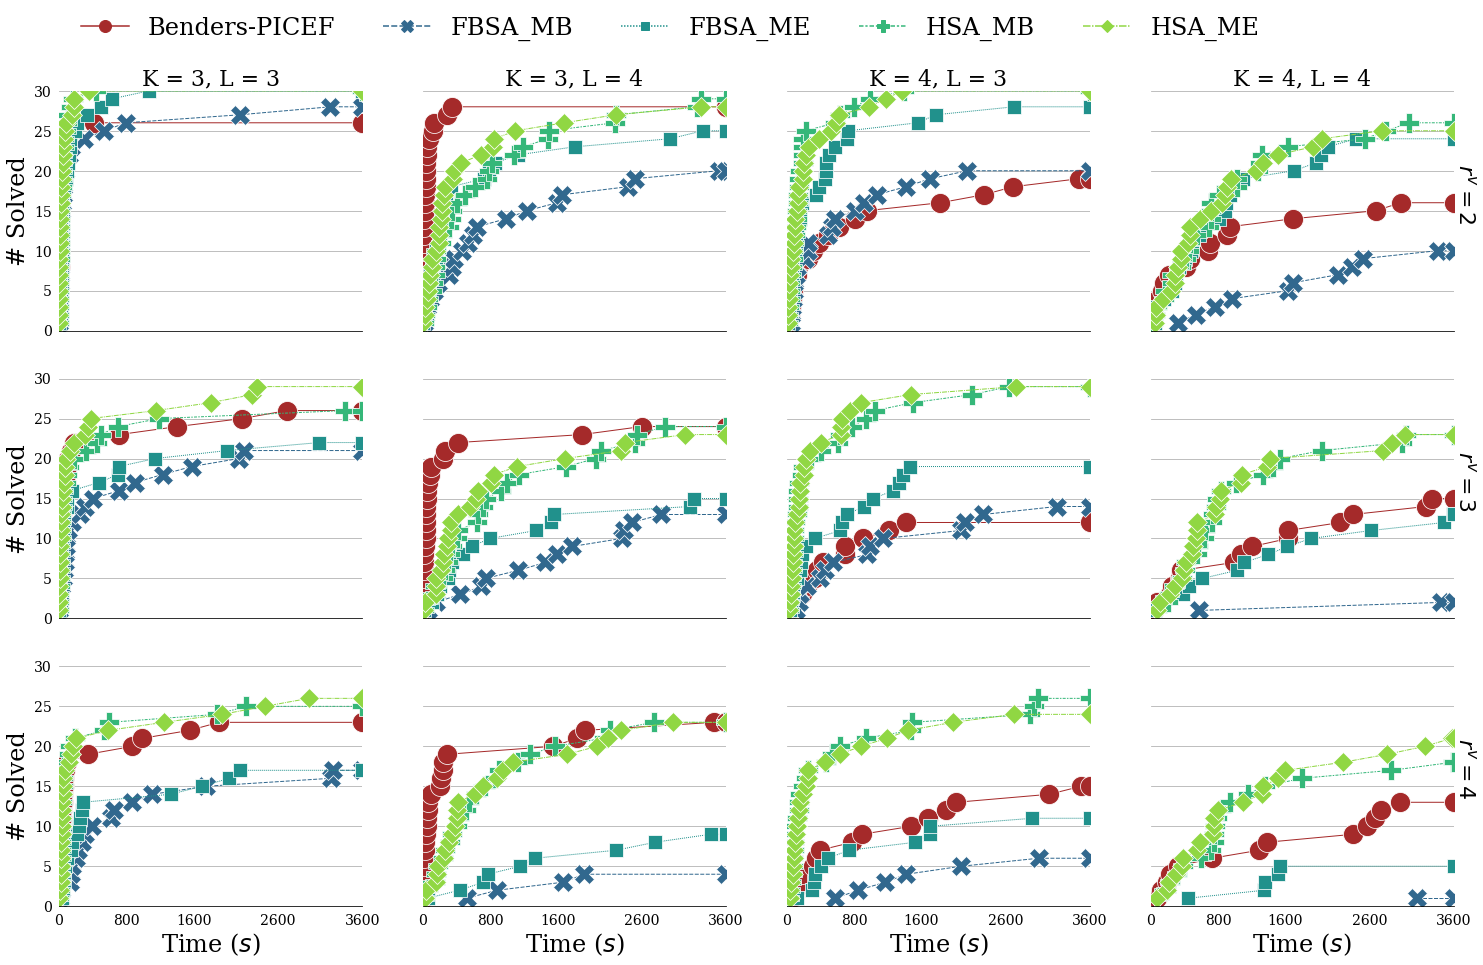

In [13]:
df_p = df_plt[
        (df_plt['tot_time'] < 3600.1) &
        (df_plt['L'] < 5) &
        (df_plt['ArcBudget'] == 0) &
        (df_plt['Policy'] == 'Full') &
        (~df_plt['LB'].isin(['Simple'])) & 
        (~df_plt['Method'].isin(['Benders'])) & 
    (df_plt['PDP'] == 100)]
fig, axes  = plt.subplots(
    figsize = (25,15),
    ncols = len(df_p['K'].unique())*len(df_p['L'].unique()),
    nrows = len(df_plt['VertexBudget'].unique()),
    sharex = True,
    sharey=True,
)
pal = seaborn.color_palette("viridis", len(df_p['name'].unique()))
pal_map ={}
for i, n in enumerate(sorted(df_p['name'].unique())):
    if (n != 'Benders-PICEF'):
        pal_map[n] = pal[i]
    else:
        pal_map[n] = 'brown'

kl_list = []
n = 0
for k in sorted(df_p['K'].unique()):
    for l in sorted(df_p['L'].unique()):    
        kl_list.append((k,l))
        n+=1

for j, v in enumerate(sorted(df_plt['VertexBudget'].unique())):
    for i, (k,l) in enumerate(kl_list):
        ax = axes[j,i]
        df_tmp = df_p[(df_p['K'] == k) & (df_p['L'] == l) & (df_p['VertexBudget'] == v)].sort_values('name')
        g = seaborn.lineplot( 
            data = df_tmp,
            x = 'tot_time',
            y = 'idx',
            hue ='name',
            markers = True,
            markersize = 20,
            style = 'name',
            ax = ax,
            color = 'black',
            palette =  [pal_map[n] for n in sorted(df_tmp['name'].unique())],#'black',
            linewidth=1
           )
        axes[j,0].set_ylabel('# Solved', fontsize=24)
        ax.legend().remove()
        if j > 0:
            axes[j,i].set_xlabel('Time ($s$)', fontsize=24)
        if j == 0:
            ax.set_title(f'K = {k}, L = {l}', fontsize=22)
        if (ax == axes[j,3]):
            g.annotate(f'$r^v = {v}$', xy = (3600,14), horizontalalignment = 'left', fontsize=22, rotation = -90, 
                      fontfamily='serif')
        #if (ax == axes[1,1]):
            #g.annotate('K =' + f'{k}', xy = (3600,14), horizontalalignment = 'left', fontsize=18, rotation = -90)
        ax.xaxis.set_major_locator(ticker.FixedLocator([0, 800, 1600, 2600, 3600]))
        

axes[0,0].set_ylim([0,30])
axes[1,0].set_ylim([0,30])

#axes[1,0].set_xlabel('Time ($s$)')
#axes[1,1].set_xlabel('Time ($s$)')

axes[1,0].set_xlim([0,3600])
axes[1,1].set_xlim([0,3600])
handles, labels  = axes[1,0].get_legend_handles_labels()
# specify order
#order = [2, 3, 0, 1]
axes[1,0].legend(
    handles,
    labels,
    bbox_to_anchor=(0,2.6), 
    loc  = 'upper left',
    #borderaxespad=0,
    fontsize=24,
    ncol = 5,
)
# pass handle & labels lists along with order as below

multi_savefig("performance_profile")

In [14]:
#df[(df['K'] == 3) & (df['L'] == 4) & (df['VertexBudget'] == 2) & (df['name'] == 'BHSA_Basic')]
#df_plt[(df_plt['K'] == 4) & (df_plt['L'] == 3) & (df_plt['VertexBudget'] == 4) & (df_plt['name'] == 'BHSA_Basic')]

In [15]:
labels

['Benders-PICEF', 'FBSA_MB', 'FBSA_ME', 'HSA_MB', 'HSA_ME']

In [16]:
ax.get_xticks()

array([   0,  800, 1600, 2600, 3600])

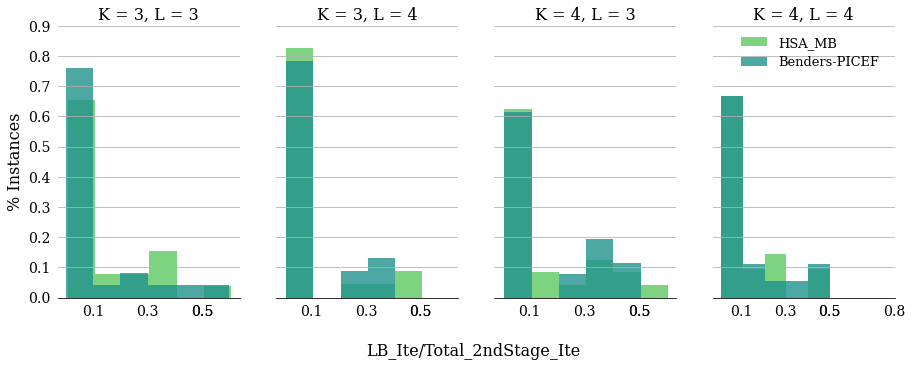

In [17]:
df_p = df_plt[
        (df_plt['status'] == 'Optimal') & (~df_plt['Method'].isin(['Benders', 'Benders-PICEF'])) & 
    (df_plt['PDP'] == 100) & (df_plt['LB'] == 'Strong') & (df_plt['VertexBudget'] == 4)]
fig, axes  = plt.subplots(
    figsize = (15,5),
    ncols = len(df_p['K'].unique()) + len(df_p['L'].unique()),
    nrows = 1,
    sharex = True,
    sharey=True
)
pal = seaborn.color_palette("viridis", len(df_p['Method'].unique()))
pal_map ={}
for i, n in enumerate(sorted(df_p['Method'].unique())):
    pal_map[n] = pal[i]
for i, k in enumerate(sorted(df_p['K'].unique())):
    for j, l in enumerate(sorted(df_p['L'].unique())):
        ax = axes[j + (i%2)*2]
        df_tmp = df_p[(df_p['L'] == l) & (df_p['K'] == k)].sort_values('name')
        g = seaborn.histplot( 
            data = df_tmp[df_tmp['Method'] == 'DoubleCovering'],
            x = 'perOPT',
            #hue = 'Method',
            ax = ax,
            stat = 'probability',
            binwidth = 0.10,
            bins = [0.5, 0.10, 0.30, 0.50, 0.80, 1],
            #color=  '#B5DD2B30',
            color=  pal_map['DoubleCovering'],
            alpha=.8,
            linewidth=0,
            multiple='stack',
            label = sorted(df_tmp['name'].unique())[1]
           )
        g = seaborn.histplot( 
            data = df_tmp[df_tmp['Method'] == 'Covering'],
            x = 'perOPT',
            #hue = 'Method',
            ax = ax,
            stat = 'probability',
            binwidth = 0.10,
            bins = [0.5, 0.10, 0.30, 0.50, 0.80, 1],
            #color=  '#D3426D10',
            color=  pal_map['Covering'],
            alpha=0.8,
            linewidth=0,
            multiple='stack',
            label = sorted(df_tmp['name'].unique())[0]
           )
        ax.set(xlabel=None)
        ax.set_ylabel('% Instances', fontsize=16)
        ax.set_xticks([0.5, 0.10, 0.30, 0.50, 0.80])
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(.25))
        
        ax.set_ylim([0, 0.9])
        if (k < 4 or l < 4):
            ax.legend().remove()
        if (k == 3 and l == 4):
            g.annotate('LB_Ite/Total_2ndStage_Ite', xy = (0.3,-0.15), horizontalalignment = 'left', verticalalignment='top', fontsize=16, annotation_clip=False)

        ax.set_title(f'K = {k}, L = {l}', fontsize=16)
        #if (j%2 == 1):
            #g.annotate(f'K = {k}', xy = (-0.35,1.05), horizontalalignment = 'left', verticalalignment='top', fontsize=16, annotation_clip=False)
axes[3].legend(
    bbox_to_anchor=(0.13, 0.98),
    loc  = 'upper left',
    borderaxespad=0,
    fontsize=13
)

plt.savefig("Histogram.pdf", bbox_inches = 'tight')

In [18]:
axes[0].get_legend_handles_labels()

([<BarContainer object of 6 artists>, <BarContainer object of 6 artists>],
 ['HSA_MB', 'Benders-PICEF'])

In [19]:
pal = seaborn.color_palette("bright", 4)
pal_map ={}
for i, n in enumerate(sorted(df_p['name'].unique())):
    pal_map[n] = pal[i]

In [20]:
pal_map


{'Benders-PICEF': (0.00784313725490196, 0.24313725490196078, 1.0),
 'HSA_MB': (1.0, 0.48627450980392156, 0.0),
 'HSA_ME': (0.10196078431372549, 0.788235294117647, 0.2196078431372549)}